# ANALISE E MODELAGEM DE DADOS

# Iniciando sessão spark

In [1]:
import findspark
import os

findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Iniciando com Spark") \
    .getOrCreate()

# Imports

In [2]:
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml.stat import Correlation
from pyspark.sql import Window

# Carregando dados

In [3]:
produtos = spark.read.csv('teste_petz/Produtos.csv', sep = ';', header = True)
vendas = spark.read.csv('teste_petz/Vendas.csv', sep = ';', header = True)
lojas = spark.read.csv('teste_petz/Lojas.csv', sep = ';', header = True)
unidades = spark.read.csv('teste_petz/Unidades_Negocios.csv', sep = ';', header = True)
canais = spark.read.csv('teste_petz/Canais.csv', sep = ';', header = True)

# Mostrando os dados

In [118]:
lista_dfs = {'produtos':produtos,
            'vendas':vendas,
            'lojas':lojas,
            'unidades':unidades,
            'canais':canais}
for i, j in lista_dfs.items():
    print(i + ' tabela: ')
    print(j.show(5))
    print('contagem: ')
    print(j.count())
    print('-------------------------------')

produtos tabela: 
+--------------------+------------+------------+-----------+-----------------+
|             produto|  fornecedor|produto_nome|  categoria|    sub_categoria|
+--------------------+------------+------------+-----------+-----------------+
|K*C+26:7*$6P)3PQ_...|Fornecedor 1|   Produto 1|Categoria 1|Subcategoria C1.1|
|A],V_4=/EP2<3_]5N...|Fornecedor 2|   Produto 2|Categoria 1|Subcategoria C1.1|
|EL2!F4Q5(;*)$XX7S...|Fornecedor 3|   Produto 3|Categoria 1|Subcategoria C1.1|
|"EL""=U15GB/W)$<?...|Fornecedor 3|   Produto 4|Categoria 1|Subcategoria C1.1|
|"AC""""8K\_G,V\'R...|Fornecedor 4|   Produto 5|Categoria 1|Subcategoria C1.1|
+--------------------+------------+------------+-----------+-----------------+
only showing top 5 rows

None
contagem: 
15260
-------------------------------
vendas tabela: 
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------

# Preparando dataset unificado final para modelagem

In [10]:
# Preparação inicial
dataset = vendas.withColumn('qtde_venda', regexp_replace('qtde_venda', ',', '.').cast('float'))\
        .withColumn('valor_venda', regexp_replace('valor_venda', ',', '.').cast('float'))\
        .withColumn('valor_imposto', regexp_replace('valor_imposto', ',', '.').cast('float'))\
        .withColumn('valor_custo', regexp_replace('valor_custo', ',', '.').cast('float'))\
        .withColumn('data', concat_ws('-', substring(col('id_data').cast('date'), 1, 4), 
                                      substring(col('id_data').cast('date'), 6, 2)))\
        .join(produtos.withColumnRenamed('produto', 'id_produto'), on='id_produto', how='left')\
        .withColumn('flg_prodt', when(isnull(col('produto_nome')), 0).otherwise(1))\
        .join(lojas, on='id_loja', how='left').withColumn('flg_loja', when(isnull(col('cod_loja')), 0).otherwise(1))\
        .join(unidades, on='id_unidade_negocio', how='left').withColumn('flg_unidade', when(isnull(col('unidade_negocio')), 
                                                                                           0).otherwise(1))\
        .join(canais.withColumnRenamed('cod_canal', 'id_canal'), on='id_canal', how='left')\
        .withColumn('flg_canal', when(isnull(col('canal')), 0).otherwise(1))

# Enumerando clientes
cliente = dataset.select('id_cliente').distinct().withColumn('cliente', concat_ws('_', lit('cliente'), 
                                                                                  monotonically_increasing_id()))

# Enumerando tipos de clientes
tipo_cliente = dataset.select('id_tipo_cliente').distinct().withColumn('tipo_cliente', 
                                                                    concat_ws('_', lit('tipo_cliente'), 
                                                                              monotonically_increasing_id()))

# Sintetizando dados em uma nova versão
dataset_v02 = dataset.join(cliente, on='id_cliente', how='left').join(tipo_cliente, on='id_tipo_cliente', how='left')\
                    .drop('id_produto', 'id_loja', 'id_unidade_negocio', 'id_canal', 'id_cupom', 
                          'id_cliente', 'id_endereco_venda', 'id_tipo_cliente', 'id_data').distinct().cache()

# Exibindo Dataset

In [122]:
dataset_v02.show()

+----------+-----------+-------------+-----------+-------+--------------+-------------+--------------+-----------------+---------+--------+------------+----------+-------------+--------------+---+--------+---------------+-----------+-----+---------+--------------------+--------------------+
|qtde_venda|valor_venda|valor_imposto|valor_custo|   data|    fornecedor| produto_nome|     categoria|    sub_categoria|flg_prodt|cod_loja|ano_abertura|  regional|     distrito|        cidade| uf|flg_loja|unidade_negocio|flg_unidade|canal|flg_canal|             cliente|        tipo_cliente|
+----------+-----------+-------------+-----------+-------+--------------+-------------+--------------+-----------------+---------+--------+------------+----------+-------------+--------------+---+--------+---------------+-----------+-----+---------+--------------------+--------------------+
|      null|       null|          1.2|      6.588|2018-05|      H-H'&N(G|           ,"|Fornecedor 151|    Produto 15129|    

In [ ]:
+----------+-----------+-------------+-----------+-------+--------------+-------------+--------------+-----------------+---------+--------+------------+----------+-------------+--------------+---+--------+---------------+-----------+-----+---------+--------------------+--------------------+
|qtde_venda|valor_venda|valor_imposto|valor_custo|   data|    fornecedor| produto_nome|     categoria|    sub_categoria|flg_prodt|cod_loja|ano_abertura|  regional|     distrito|        cidade| uf|flg_loja|unidade_negocio|flg_unidade|canal|flg_canal|             cliente|        tipo_cliente|
+----------+-----------+-------------+-----------+-------+--------------+-------------+--------------+-----------------+---------+--------+------------+----------+-------------+--------------+---+--------+---------------+-----------+-----+---------+--------------------+--------------------+
|      null|       null|          1.2|      6.588|2018-05|      H-H'&N(G|           ,"|Fornecedor 151|    Produto 15129|        1|  Loja 3|        2017|Regional 2|Distrito R2.2|      Brasilia| DF|       1|       Produtos|          1| Loja|        1|cliente_240518168586|     tipo_cliente_85|
|    -32.52|     -8.862|      -11.604|       null|2018-11| Fornecedor 83| Produto 7343|   Categoria 5|Subcategoria C5.1|        1|  Loja 5|        2018|Regional 1|Distrito R1.2|        Santos| SP|       1|       Produtos|          1| Loja|        1|cliente_317827580058|     tipo_cliente_27|
|      null|        0.6|       90.804|      8.394|2019-08| Fornecedor 26|Produto 12881|   Categoria 2|Subcategoria C2.2|        1|  Loja 4|        2017|Regional 1|Distrito R1.2|      Sorocaba| SP|       1|       Produtos|          1| Loja|        1|cliente_140015933...|      tipo_cliente_1|
|      null|        0.6|       51.594|     14.064|2019-08|Fornecedor 110|Produto 11383|   Categoria 7|Subcategoria C7.1|        1|  Loja 4|        2017|Regional 1|Distrito R1.2|      Sorocaba| SP|       1|       Produtos|          1| Loja|        1|cliente_140015933...|      tipo_cliente_1|
|      null|        0.6|       17.994|       3.24|2018-05| Fornecedor 31|Produto 10505|   Categoria 5|Subcategoria C5.1|        1|  Loja 5|        2018|Regional 1|Distrito R1.2|        Santos| SP|       1|       Produtos|          1| Loja|        1|cliente_130567005...|     tipo_cliente_92|
|      null|        1.2|       14.388|      3.924|2018-07|Fornecedor 211| Produto 9183|   Categoria 7|Subcategoria C7.1|        1|  Loja 3|        2017|Regional 2|Distrito R2.2|      Brasilia| DF|       1|       Produtos|          1| Loja|        1|cliente_109092169...|     tipo_cliente_82|
|      null|        1.2|        9.588|      2.616|2018-10|Fornecedor 230| Produto 4717|   Categoria 1|Subcategoria C1.1|        1|  Loja 2|        2011|Regional 2|Distrito R2.1|Rio de Janeiro| RJ|       1|       Produtos|          1| Loja|        1|cliente_566935684109|    tipo_cliente_271|
|      null|        0.6|       15.696|      4.278|2018-12| Fornecedor 41| Produto 6506|   Categoria 2|Subcategoria C2.2|        1|  Loja 4|        2017|Regional 1|Distrito R1.2|      Sorocaba| SP|       1|       Produtos|          1| Loja|        1|cliente_446676598949|     tipo_cliente_24|
|      null|        0.6|        9.594|      1.722|2018-11| Fornecedor 60|  Produto 446|   Categoria 7|Subcategoria C7.1|        1|  Loja 4|        2017|Regional 1|Distrito R1.2|      Sorocaba| SP|       1|       Produtos|          1| Loja|        1|cliente_188978561476|tipo_cliente_8589...|
|      null|        0.6|       38.082|     10.374|2018-12|Fornecedor 218| Produto 9264|   Categoria 7|Subcategoria C7.1|        1|  Loja 3|        2017|Regional 2|Distrito R2.2|      Brasilia| DF|       1|       Produtos|          1| Loja|        1|cliente_738734376275|tipo_cliente_8589...|
|      null|        1.8|       48.042|     13.086|2019-07|  Fornecedor 2| Produto 9181|   Categoria 7|Subcategoria C7.1|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|     Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|cliente_764504178957|tipo_cliente_8589...|
|      null|        0.6|       11.994|       1.11|2019-08|Fornecedor 198|Produto 13044|   Categoria 5|Subcategoria C5.3|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|     Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|cliente_109951162...|tipo_cliente_8589...|
|     2.562|       null|         null|       null|2018-02|Fornecedor 106| Produto 1661|   Categoria 7|Subcategoria C7.1|        1|  Loja 3|        2017|Regional 2|Distrito R2.2|      Brasilia| DF|       1|       Produtos|          1| Loja|        1|cliente_121118077...|tipo_cliente_8589...|
|     2.778|      3.414|         null|       null|2018-06|Fornecedor 161| Produto 6240|   Categoria 1|Subcategoria C1.1|        1|  Loja 4|        2017|Regional 1|Distrito R1.2|      Sorocaba| SP|       1|       Produtos|          1| Loja|        1|cliente_712964571160|tipo_cliente_8589...|
|      null|        1.2|       23.988|      6.534|2019-08| Fornecedor 95| Produto 6431|   Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|     Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|cliente_644245094681|tipo_cliente_8589...|
|      null|        0.6|        33.12|      3.066|2018-07| Fornecedor 63| Produto 5147|   Categoria 7|Subcategoria C7.3|        1|  Loja 3|        2017|Regional 2|Distrito R2.2|      Brasilia| DF|       1|       Servicos|          1| Loja|        1|cliente_609885356245|tipo_cliente_8589...|
|      null|        0.6|       23.994|       2.22|2018-06| Fornecedor 26|Produto 11900|   Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|     Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|cliente_147746874...|tipo_cliente_8589...|
|      null|        0.6|       24.636|       2.28|2018-02| Fornecedor 26|Produto 11900|   Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|     Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|cliente_147746874...|tipo_cliente_8589...|
|      null|        1.8|        3.762|      0.342|2018-10|          V^+"|Fornecedor 95|  Produto 8894|      Categoria 2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|     Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|cliente_120259084...|tipo_cliente_8589...|
|      null|       null|          0.6|      5.322|2018-05|Fornecedor 190| Produto 4338|   Categoria 2|Subcategoria C2.2|        1|  Loja 3|        2017|Regional 2|Distrito R2.2|      Brasilia| DF|       1|       Produtos|          1| Loja|        1|cliente_403726926092|tipo_cliente_8589...|
+----------+-----------+-------------+-----------+-------+--------------+-------------+--------------+-----------------+---------+--------+------------+----------+-------------+--------------+---+--------+---------------+-----------+-----+---------+--------------------+--------------------+

# Contagem total

In [124]:
dataset_v02.count()

3759230

# Total de clientes

In [125]:
dataset_v02.select('cliente').distinct().count()

353290

# Total de tipos de clientes

In [126]:
dataset_v02.select('tipo_cliente').distinct().count()

88064

# Contagem de nulos

In [127]:
dataset_v02.select([count(when(isnull(col(c)), c)).alias(c) for c in dataset_v02.columns]).show()

+----------+-----------+-------------+-----------+----+----------+------------+---------+-------------+---------+--------+------------+--------+--------+------+---+--------+---------------+-----------+-----+---------+-------+------------+
|qtde_venda|valor_venda|valor_imposto|valor_custo|data|fornecedor|produto_nome|categoria|sub_categoria|flg_prodt|cod_loja|ano_abertura|regional|distrito|cidade| uf|flg_loja|unidade_negocio|flg_unidade|canal|flg_canal|cliente|tipo_cliente|
+----------+-----------+-------------+-----------+----+----------+------------+---------+-------------+---------+--------+------------+--------+--------+------+---+--------+---------------+-----------+-----+---------+-------+------------+
|    873069|     117191|        19505|      28359|   0|      8466|        7785|     7785|         7761|        0|       0|           0|       0|       0|     0|  0|       0|              0|          0|    0|        0|   2304|        2156|
+----------+-----------+-------------+------

In [ ]:
+----------+-----------+-------------+-----------+----+----------+------------+---------+-------------+---------+--------+------------+--------+--------+------+---+--------+---------------+-----------+-----+---------+-------+------------+
|qtde_venda|valor_venda|valor_imposto|valor_custo|data|fornecedor|produto_nome|categoria|sub_categoria|flg_prodt|cod_loja|ano_abertura|regional|distrito|cidade| uf|flg_loja|unidade_negocio|flg_unidade|canal|flg_canal|cliente|tipo_cliente|
+----------+-----------+-------------+-----------+----+----------+------------+---------+-------------+---------+--------+------------+--------+--------+------+---+--------+---------------+-----------+-----+---------+-------+------------+
|    873069|     117191|        19505|      28359|   0|      8466|        7785|     7785|         7761|        0|       0|           0|       0|       0|     0|  0|       0|              0|          0|    0|        0|   2304|        2156|
+----------+-----------+-------------+-----------+----+----------+------------+---------+-------------+---------+--------+------------+--------+--------+------+---+--------+---------------+-----------+-----+---------+-------+------------+

# Tratando nulos & corrigindo dados equivocados

## Corrigindo variáveis contínuas negativas & Corrigindo categorias erradas!

In [11]:
dataset_v03 = dataset_v02.where(col('qtde_venda') >= 0).where(col('valor_venda') > 0)\
    .where(col('valor_imposto') > 0).where(col('valor_custo') > 0)\
    .withColumn('fornecedor', when(substring(col('fornecedor'), 1, 4) != 'Forn', None).otherwise(col('fornecedor')))\
    .withColumn('produto_nome', when(substring(col('produto_nome'), 1, 4) != 'Prod', None).otherwise(col('produto_nome')))\
    .withColumn('categoria', when(substring(col('categoria'), 1, 4) != 'Cate', None).otherwise(col('categoria')))\
    .withColumn('sub_categoria', when(substring(col('sub_categoria'), 1, 3) != 'Sub', None).otherwise(col('sub_categoria')))\
    .withColumn('cod_loja', when(substring(col('cod_loja'), 1, 4) != 'Loja', None).otherwise(col('cod_loja')))\
    .withColumn('regional', when(substring(col('regional'), 1, 4) != 'Regi', None).otherwise(col('regional')))\
    .withColumn('distrito', when(substring(col('distrito'), 1, 4) != 'Dist', None).otherwise(col('distrito')))\
    .withColumn('cliente', when(substring(col('cliente'), 1, 4) != 'clie', None).otherwise(col('cliente')))\
    .withColumn('tipo_cliente', when(substring(col('tipo_cliente'), 1, 4) != 'tipo', None).otherwise(col('tipo_cliente')))\
    .cache()

#### Contagem

##### Antes
dataset_v02.count() = 3759230

In [130]:
# Depois
dataset_v03.count()

2652821

## Contando novamente os nulos

In [131]:
dataset_v03.select([count(when(isnull(col(c)), c)).alias(c) for c in dataset_v03.columns]).show()

+----------+-----------+-------------+-----------+----+----------+------------+---------+-------------+---------+--------+------------+--------+--------+------+---+--------+---------------+-----------+-----+---------+-------+------------+
|qtde_venda|valor_venda|valor_imposto|valor_custo|data|fornecedor|produto_nome|categoria|sub_categoria|flg_prodt|cod_loja|ano_abertura|regional|distrito|cidade| uf|flg_loja|unidade_negocio|flg_unidade|canal|flg_canal|cliente|tipo_cliente|
+----------+-----------+-------------+-----------+----+----------+------------+---------+-------------+---------+--------+------------+--------+--------+------+---+--------+---------------+-----------+-----+---------+-------+------------+
|         0|          0|            0|          0|   0|      3426|        3426|     3426|         3426|        0|       0|           0|       0|       0|     0|  0|       0|              0|          0|    0|        0|      4|           0|
+----------+-----------+-------------+------

In [ ]:
+----------+-----------+-------------+-----------+----+----------+------------+---------+-------------+---------+--------+------------+--------+--------+------+---+--------+---------------+-----------+-----+---------+-------+------------+
|qtde_venda|valor_venda|valor_imposto|valor_custo|data|fornecedor|produto_nome|categoria|sub_categoria|flg_prodt|cod_loja|ano_abertura|regional|distrito|cidade| uf|flg_loja|unidade_negocio|flg_unidade|canal|flg_canal|cliente|tipo_cliente|
+----------+-----------+-------------+-----------+----+----------+------------+---------+-------------+---------+--------+------------+--------+--------+------+---+--------+---------------+-----------+-----+---------+-------+------------+
|         0|          0|            0|          0|   0|      3426|        3426|     3426|         3426|        0|       0|           0|       0|       0|     0|  0|       0|              0|          0|    0|        0|      4|           0|
+----------+-----------+-------------+-----------+----+----------+------------+---------+-------------+---------+--------+------------+--------+--------+------+---+--------+---------------+-----------+-----+---------+-------+------------+

## Tendo em vista um número não elevado de nulos, optou-se por dropar registros nulos

In [12]:
dataset_v04 = dataset_v03.dropna()

# Agregando variáveis em relação ao tempo (mensal)

In [13]:
# Agregando variáveis numéricas
dataset_numeric_agg = dataset_v04.select('produto_nome', 'data', 
                                'qtde_venda', 'valor_venda', 
                                'valor_imposto', 'valor_custo').groupBy('produto_nome', 'data').sum()\
                .withColumnRenamed('sum(qtde_venda)', 'qtd_venda_mensal')\
                .withColumnRenamed('sum(valor_venda)', 'valor_venda_mensal')\
                .withColumnRenamed('sum(valor_imposto)', 'valor_imposto_mensal')\
                .withColumnRenamed('sum(valor_custo)', 'valor_custo_mensal')

# Separando as variáveis categóricas
dataset_cat = dataset_v04.drop('qtde_venda', 'valor_venda', 'valor_imposto', 'valor_custo', 'data', 'cliente').distinct()

# Nova versão do dataset
dataset_v05 = dataset_cat.join(dataset_numeric_agg, on='produto_nome', how='left')

In [134]:
dataset_v05.show()

+-------------+-------------+-----------+-----------------+---------+--------+------------+----------+-------------+---------+---+--------+---------------+-----------+-----+---------+--------------------+-------+------------------+------------------+--------------------+------------------+
| produto_nome|   fornecedor|  categoria|    sub_categoria|flg_prodt|cod_loja|ano_abertura|  regional|     distrito|   cidade| uf|flg_loja|unidade_negocio|flg_unidade|canal|flg_canal|        tipo_cliente|   data|  qtd_venda_mensal|valor_venda_mensal|valor_imposto_mensal|valor_custo_mensal|
+-------------+-------------+-----------+-----------------+---------+--------+------------+----------+-------------+---------+---+--------+---------------+-----------+-----+---------+--------------------+-------+------------------+------------------+--------------------+------------------+
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| 

In [ ]:
+-------------+-------------+-----------+-----------------+---------+--------+------------+----------+-------------+---------+---+--------+---------------+-----------+-----+---------+--------------------+-------+------------------+------------------+--------------------+------------------+
| produto_nome|   fornecedor|  categoria|    sub_categoria|flg_prodt|cod_loja|ano_abertura|  regional|     distrito|   cidade| uf|flg_loja|unidade_negocio|flg_unidade|canal|flg_canal|        tipo_cliente|   data|  qtd_venda_mensal|valor_venda_mensal|valor_imposto_mensal|valor_custo_mensal|
+-------------+-------------+-----------+-----------------+---------+--------+------------+----------+-------------+---------+---+--------+---------------+-----------+-----+---------+--------------------+-------+------------------+------------------+--------------------+------------------+
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2019-02|  91.2000036239624| 1708.524010181427|  157.93799704313278| 877.0080127716064|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2019-12|117.60000455379486|2263.4580125808716|  210.02999711036682|1102.0620074272156|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2018-05|  60.0000022649765|1147.8420009613037|  106.01999735832214| 563.1599955558777|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2019-07|113.40000450611115|2155.5540103912354|  199.06799584627151|1076.8199772834778|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2018-12| 78.00000309944153| 1487.382004737854|  137.40599697828293| 734.1539855003357|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2018-11| 88.20000338554382|1664.7900052070618|  153.76799723505974| 830.0639853477478|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2019-05|117.60000467300415|2222.0640058517456|  212.75999557971954|1114.3980026245117|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2019-06|100.20000398159027|1896.0060052871704|  175.17599654197693| 946.4039769172668|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2019-11|109.20000433921814|2072.5500049591064|  191.45999604463577|1003.5840034484863|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2018-01| 45.00000178813934| 897.5040216445923|   83.02800101041794|434.55600452423096|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2019-04|103.80000412464142|1958.2680096626282|  180.85799649357796| 981.2040138244629|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2018-07| 66.60000264644623|1256.7059988975525|  116.08199715614319|  628.416018486023|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2018-08| 61.20000231266022| 1151.124002456665|   106.3259973526001| 571.9440159797668|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2018-09|  68.4000027179718| 1293.204005241394|  119.45399725437164| 641.8260045051575|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2019-10| 93.00000369548798|1795.6200122833252|      165.8759983778| 864.8699898719788|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2018-03| 65.40000259876251|1315.5720233917236|  121.69200044870377| 601.0080041885376|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2019-08| 95.40000379085541| 1798.890009880066|   169.7459967136383| 892.7399883270264|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2019-01| 89.40000355243683|1692.2820081710815|  156.26999682188034| 848.1299958229065|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2018-02|44.400001764297485| 879.8160228729248|   81.39600110054016| 418.9860053062439|
|Produto 11042|Fornecedor 26|Categoria 2|Subcategoria C2.2|        1|  Loja 1|        2013|Regional 1|Distrito R1.1|Sao Paulo| SP|       1|       Produtos|          1| Loja|        1|tipo_cliente_1546...|2018-10| 82.20000314712524| 1553.280005455017|  143.46599760651588| 774.0359950065613|
+-------------+-------------+-----------+-----------------+---------+--------+------------+----------+-------------+---------+---+--------+---------------+-----------+-----+---------+--------------------+-------+------------------+------------------+--------------------+------------------+
only showing top 20 rows

# Sumário das variáveis numéricas & Esquema geral

In [135]:
dataset_v05.printSchema()
dataset_v05.select('qtd_venda_mensal', 'valor_venda_mensal', 'valor_imposto_mensal', 'valor_custo_mensal').summary().show()

root
 |-- produto_nome: string (nullable = true)
 |-- fornecedor: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- sub_categoria: string (nullable = true)
 |-- flg_prodt: integer (nullable = false)
 |-- cod_loja: string (nullable = true)
 |-- ano_abertura: string (nullable = true)
 |-- regional: string (nullable = true)
 |-- distrito: string (nullable = true)
 |-- cidade: string (nullable = true)
 |-- uf: string (nullable = true)
 |-- flg_loja: integer (nullable = false)
 |-- unidade_negocio: string (nullable = true)
 |-- flg_unidade: integer (nullable = false)
 |-- canal: string (nullable = true)
 |-- flg_canal: integer (nullable = false)
 |-- tipo_cliente: string (nullable = true)
 |-- data: string (nullable = true)
 |-- qtd_venda_mensal: double (nullable = true)
 |-- valor_venda_mensal: double (nullable = true)
 |-- valor_imposto_mensal: double (nullable = true)
 |-- valor_custo_mensal: double (nullable = true)

+-------+------------------+--------------------+

# Box-plot

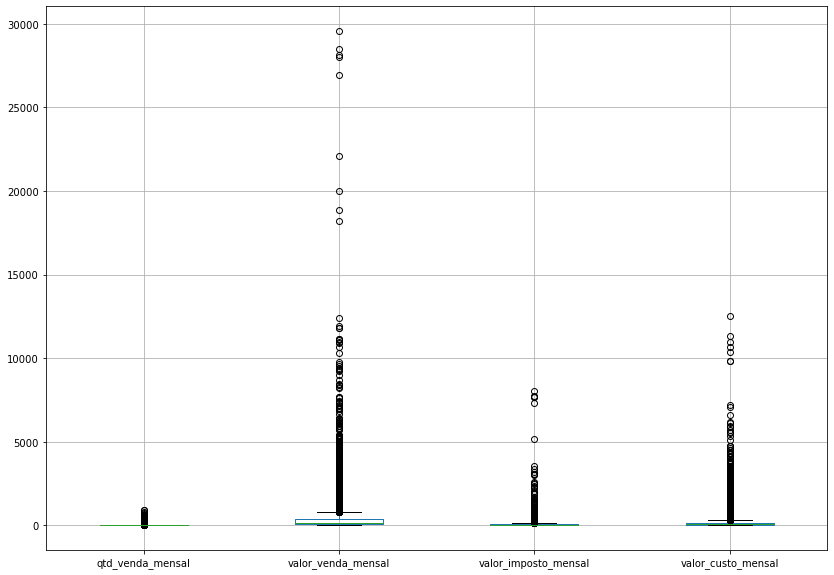

In [136]:
numeric_cols = ['qtd_venda_mensal', 'valor_venda_mensal', 'valor_imposto_mensal', 'valor_custo_mensal']
# Passando para o pandas
df_pd = dataset_v05.select(numeric_cols).groupBy(numeric_cols).count().sample(fraction = 0.05).toPandas()
df_pd.boxplot(column = numeric_cols, figsize = (14,10))
plt.show()

# Retirando outliers

In [14]:
# Como observado, existem diversos outliers, de acordo com o sumário e o box-plot, removeremos alguns destes

dataset_v06 = dataset_v05.where(col('qtd_venda_mensal') < 60).where(col('valor_venda_mensal') < 1500)\
                        .where(col('valor_imposto_mensal') < 200).where(col('valor_custo_mensal') < 600)

# Contagem antes e após remoção de outliers

In [138]:
# Antes

dataset_v05.count()

1774489

In [139]:
# Depois

dataset_v06.count()

1392716

# Histogramas

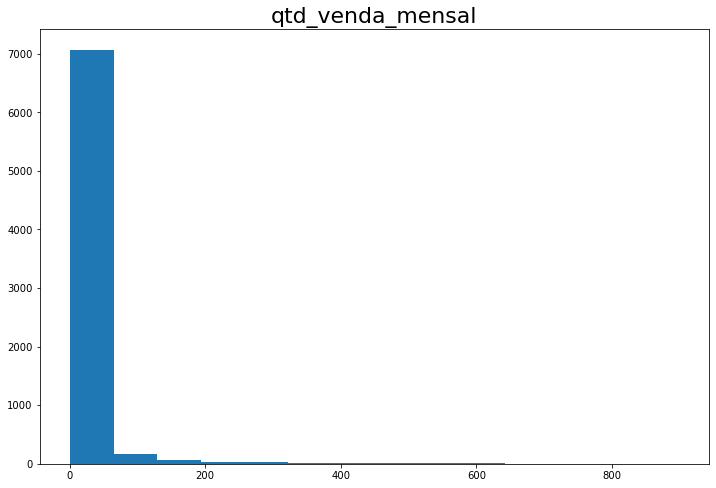

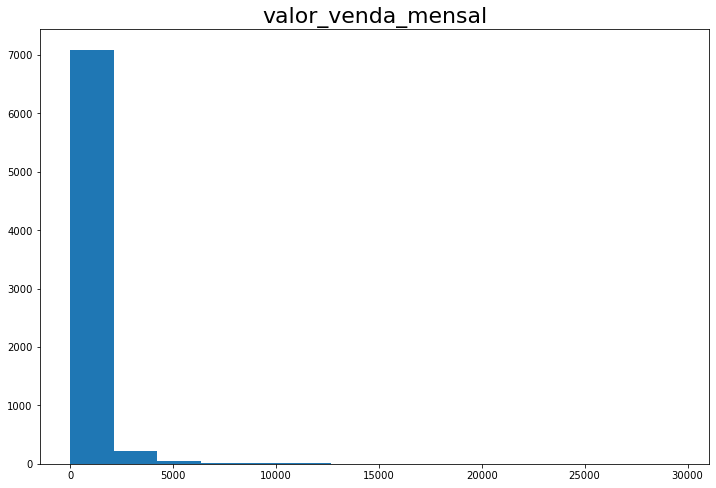

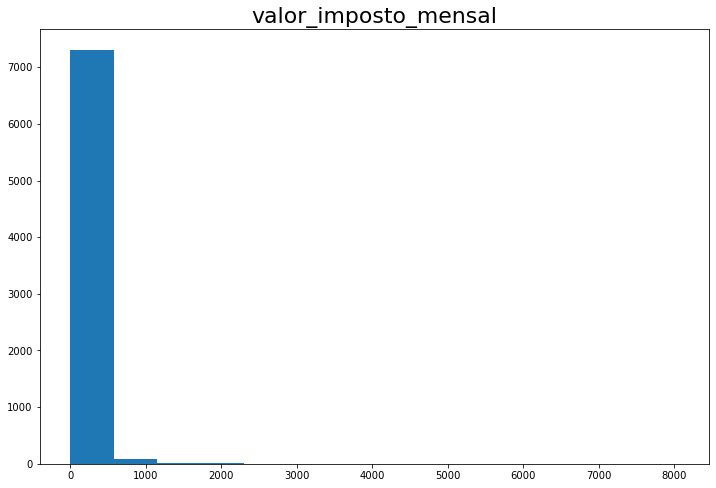

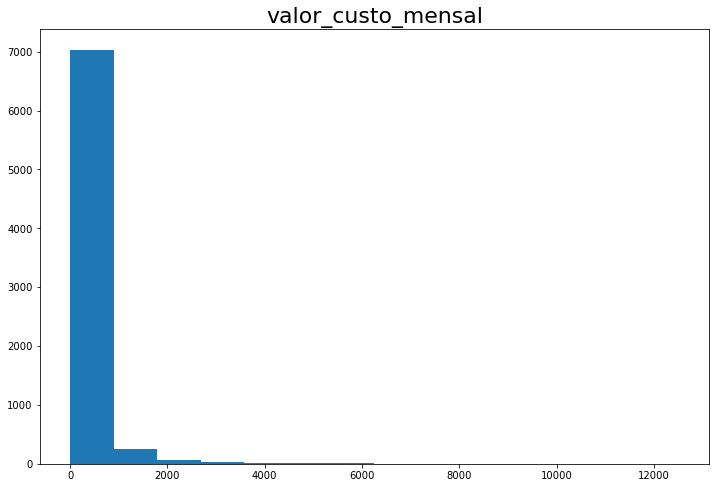

In [140]:
# df_pd = dataset_v06.select(numeric_cols).groupBy(numeric_cols).count().sample(fraction = 0.05).toPandas()
for i in numeric_cols:
    plt.figure(figsize = (12, 8))
    plt.title(i, fontsize = 22)
    plt.hist(df_pd[i], bins = 14)

### Como é possível observar, as variáveis são assimétricas

# Selecionando datas para os dados a serem modelados

In [141]:
# Avaliando intervalo de tempo disponível

dataset_v06.select('data').distinct().orderBy('data', ascending = False).show(200)

+-------+
|   data|
+-------+
|2019-12|
|2019-11|
|2019-10|
|2019-09|
|2019-08|
|2019-07|
|2019-06|
|2019-05|
|2019-04|
|2019-03|
|2019-02|
|2019-01|
|2018-12|
|2018-11|
|2018-10|
|2018-09|
|2018-08|
|2018-07|
|2018-06|
|2018-05|
|2018-04|
|2018-03|
|2018-02|
|2018-01|
+-------+



In [142]:
# Separando os últimos 6 meses para a modelagem

num_meses = 6
data_primeira = dataset_v06.select('data').distinct().orderBy('data', ascending = False).collect()[num_meses-1]
dataset_v07 = dataset_v06.where(col('data') >= data_primeira[0])

# Recontagem de registros para o intervalo de tempo selecionado

In [143]:
dataset_v07.count()

361177

# Parametrizando coluna de datas

In [162]:
data_sequencia = dataset_v07.select('data').distinct().orderBy('data').withColumn('data_sequencia', 
                                                                                  (monotonically_increasing_id() + 1))
dataset_v08 = dataset_v07.join(data_sequencia, on='data', how='left').distinct()

# Persistindo na base o dataset final após estudos

In [163]:
dataset_v08.toPandas().to_csv('teste_petz/saves/dataset_processado.csv') # .write.format('csv').mode('overwrite').saveAsTable()

# Recarregando Dataset

In [4]:
dataset_v08 = spark.read.csv('teste_petz/saves/dataset_processado.csv', header = True)

# Selecionando variáveis de interesse para modelagem

##### Parâmetros

In [5]:
# Para uma projeção de vendas de produtos, foram selecionadas variáveis contínuas para um modelo de regressão!
# Coluna de produtos
pk_col = 'produto_nome'
# Variáveis
x_cols = ['data_sequencia', 'valor_venda_mensal', 'valor_imposto_mensal', 'valor_custo_mensal']
# Variável resposta 'y'
target = 'qtd_venda_mensal'
df = dataset_v08.select('produto_nome', col('qtd_venda_mensal').cast('float'), col('data_sequencia').cast('float'), 
                        col('valor_venda_mensal').cast('float'), col('valor_imposto_mensal').cast('float'), 
                        col('valor_custo_mensal').cast('float')).distinct()
X = dataset_v08.select(col(x_cols[0]).cast('float'),
                       col(x_cols[1]).cast('float'),
                       col(x_cols[2]).cast('float'),
                       col(x_cols[3]).cast('float')).distinct()
y = dataset_v08.select(col(target).cast('float')).distinct()

In [157]:
# Dataset completo

df.show()

+-------------+------------------+--------------+------------------+--------------------+------------------+
| produto_nome|  qtd_venda_mensal|data_sequencia|valor_venda_mensal|valor_imposto_mensal|valor_custo_mensal|
+-------------+------------------+--------------+------------------+--------------------+------------------+
|Produto 14164|3.6000001430511475|             4| 57.56399917602539|  12.131999969482422|17.525999784469604|
| Produto 4613|3.6000001430511475|             4| 348.8759956359863|   62.79599857330322| 151.6019992828369|
| Produto 1400|15.600000500679016|             4|241.80599784851074|   43.42800009250641| 89.69400095939636|
|  Produto 926|0.6000000238418579|             4| 23.97599983215332|   4.079999923706055|7.6020002365112305|
| Produto 8946| 4.200000166893005|             4|10.746000009588897|   2.933999943546951| 4.878000020980835|
| Produto 9205|21.600000858306885|             4| 716.3700151443481|   127.1579978466034|307.26600074768066|
|Produto 15135|30.6

In [158]:
# Dataset y, respostas

y.show()

+------------------+
|  qtd_venda_mensal|
+------------------+
|41.400001645088196|
|24.600000619888306|
| 48.60000193119049|
|25.200000643730164|
| 44.40000140666962|
|34.799999833106995|
|27.000000715255737|
|31.200001001358032|
|27.600000977516174|
| 49.20000159740448|
|21.600000500679016|
| 40.80000114440918|
|  26.4000004529953|
|5.3999998569488525|
| 38.40000069141388|
|16.200000524520874|
|18.600000262260437|
| 43.20000123977661|
|10.200000166893005|
|59.400001525878906|
+------------------+
only showing top 20 rows



In [159]:
# Dataset X, variáveis

X.show()

+--------------+------------------+--------------------+------------------+
|data_sequencia|valor_venda_mensal|valor_imposto_mensal|valor_custo_mensal|
+--------------+------------------+--------------------+------------------+
|             4| 40.27199935913086|  3.7260000705718994|36.060001373291016|
|             4| 173.7300000190735|    27.7319997549057| 88.97999811172485|
|             4|32.381999015808105|   8.826000213623047|  9.86400032043457|
|             4| 121.9260025024414|   33.22200083732605| 34.48800086975098|
|             4|39.797998905181885|   6.005999982357025|14.723999977111816|
|             4|121.42200088500977|  11.226000308990479| 55.39799880981445|
|             4|1082.9819869995117|  100.17599868774414| 564.2999992370605|
|             4| 248.7299976348877|  44.772000789642334|104.00400161743164|
|             4|32.453999519348145|   6.467999815940857| 8.700000047683716|
|             4| 934.8720054626465|   89.62200093269348| 437.7779941558838|
|           

# Split do dataset em treino e teste

In [6]:
dadosTrainTest = df.select('produto_nome').distinct().randomSplit([0.75, 0.25])
df_train = dadosTrainTest[0].join(df, on='produto_nome', how='inner')
df_test = dadosTrainTest[1].join(df, on='produto_nome', how='inner')

# Modelagem 1

In [181]:
assembler = VectorAssembler(inputCols = x_cols, outputCol = 'features')
dadosFeatures_train = assembler.transform(df_train).select('qtd_venda_mensal', 'features')\
                                .withColumnRenamed('qtd_venda_mensal', 'label')
dadosFeatures_test = assembler.transform(df_test).select('qtd_venda_mensal', 'features')\
                                .withColumnRenamed('qtd_venda_mensal', 'label')

In [184]:
dadosFeatures_train.show(truncate = False)

+---------+---------------------------------------------------------------+
|label    |features                                                       |
+---------+---------------------------------------------------------------+
|0.6      |[4.0,25.194000244140625,6.857999801635742,6.317999839782715]   |
|12.0     |[4.0,672.5399780273438,183.26400756835938,234.59999084472656]  |
|0.6      |[4.0,9.593999862670898,2.621999979019165,3.9059998989105225]   |
|2.4      |[4.0,143.9759979248047,39.2400016784668,52.57200241088867]     |
|4.2000003|[4.0,151.6800079345703,26.856000900268555,69.39600372314453]   |
|1.8000001|[4.0,131.3820037841797,35.802001953125,39.92399978637695]      |
|0.6      |[4.0,34.5,9.402000427246094,11.609999656677246]                |
|0.6      |[4.0,8.994000434875488,0.8339999914169312,4.079999923706055]   |
|8.400001 |[4.0,540.6840209960938,105.39600372314453,172.66200256347656]  |
|1.2      |[4.0,3.7200000286102295,1.0140000581741333,1.0859999656677246] |
|4.2000003|[

# Obtendo correlações

In [186]:
# Correlação de variáveis

correlation1 = Correlation.corr(dadosFeatures_train, 'features')
linha1 = correlation1.first()
matrix = linha1[0]
print(matrix)

DenseMatrix([[ 1.        ,  0.00210867,  0.00452825, -0.00294393],
             [ 0.00210867,  1.        ,  0.81773865,  0.96296724],
             [ 0.00452825,  0.81773865,  1.        ,  0.67747772],
             [-0.00294393,  0.96296724,  0.67747772,  1.        ]])


# Treinando modelo

In [208]:
lr = LinearRegression()
lrModel = lr.fit(dadosFeatures_train)

In [209]:
print("R2: ", lrModel.summary.r2)
print("RMSE: ", lrModel.summary.rootMeanSquaredError)

R2:  0.17663604152958823
RMSE:  7.724733633679283


In [211]:
lrModel.transform(dadosFeatures_test).show()

+---------+--------------------+------------------+
|    label|            features|        prediction|
+---------+--------------------+------------------+
|      2.4|[4.0,52.164001464...| 3.666738445709134|
|     49.2|[4.0,379.01998901...|10.002719938693536|
|3.0000002|[4.0,658.44598388...|16.711225846505442|
|1.8000001|[4.0,194.20800781...| 7.077617460543561|
|      9.0|[4.0,537.86999511...|12.994919202890648|
|      2.4|[4.0,227.58000183...| 8.833844139992044|
|      5.4|[4.0,96.041999816...| 4.509022981053711|
|36.600002|[4.0,362.60400390...|10.173163306985813|
|4.2000003|[4.0,82.068000793...|3.7976268099316526|
|      1.2|[4.0,14.574000358...| 2.972919378775683|
|      2.4|[4.0,406.30200195...|11.894421769354134|
|3.0000002|[4.0,222.34199523...| 7.635306992340736|
|      1.2|[4.0,4.7880001068...| 2.774390138495174|
|      0.6|[4.0,14.994000434...| 2.952988073651296|
|      0.6|[4.0,7.7699999809...|  2.85210662965656|
| 8.400001|[4.0,211.02000427...| 7.638061535418371|
|     37.8|[

# Modelagem 2

In [218]:
x_cols_2 = ['data_sequencia', 'valor_venda_mensal']
assembler_2 = VectorAssembler(inputCols = x_cols_2, outputCol = 'features')
dadosFeatures_train_2 = assembler_2.transform(df_train).select('qtd_venda_mensal', 'features')\
                                .withColumnRenamed('qtd_venda_mensal', 'label')
dadosFeatures_test_2 = assembler_2.transform(df_test).select('qtd_venda_mensal', 'features')\
                                .withColumnRenamed('qtd_venda_mensal', 'label')

In [219]:
lr_2 = LinearRegression()
lrModel_2 = lr_2.fit(dadosFeatures_train_2)

In [220]:
print("R2: ", lrModel_2.summary.r2)
print("RMSE: ", lrModel_2.summary.rootMeanSquaredError)

R2:  0.16033951086862241
RMSE:  7.8008054250340315


# Modelagem 3

In [221]:
x_cols_3 = ['data_sequencia', 'valor_venda_mensal', 'valor_imposto_mensal']
assembler_3 = VectorAssembler(inputCols = x_cols_3, outputCol = 'features')
dadosFeatures_train_3 = assembler_3.transform(df_train).select('qtd_venda_mensal', 'features')\
                                .withColumnRenamed('qtd_venda_mensal', 'label')
dadosFeatures_test_3 = assembler_3.transform(df_test).select('qtd_venda_mensal', 'features')\
                                .withColumnRenamed('qtd_venda_mensal', 'label')

In [222]:
lr_3 = LinearRegression()
lrModel_3 = lr_3.fit(dadosFeatures_train_3)

In [224]:
print("R2: ", lrModel_3.summary.r2)
print("RMSE: ", lrModel_3.summary.rootMeanSquaredError)

R2:  0.1679476922966876
RMSE:  7.765383371081166


# Modelagem 4

In [225]:
x_cols_4 = ['data_sequencia', 'valor_imposto_mensal']
assembler_4 = VectorAssembler(inputCols = x_cols_4, outputCol = 'features')
dadosFeatures_train_4 = assembler_4.transform(df_train).select('qtd_venda_mensal', 'features')\
                                .withColumnRenamed('qtd_venda_mensal', 'label')
dadosFeatures_test_4 = assembler_4.transform(df_test).select('qtd_venda_mensal', 'features')\
                                .withColumnRenamed('qtd_venda_mensal', 'label')

In [226]:
lr_4 = LinearRegression()
lrModel_4 = lr_4.fit(dadosFeatures_train_4)

In [227]:
print("R2: ", lrModel_4.summary.r2)
print("RMSE: ", lrModel_4.summary.rootMeanSquaredError)

R2:  0.14268649487235563
RMSE:  7.8823809326632635


# Modelagem 5

In [228]:
x_cols_5 = ['data_sequencia', 'valor_custo_mensal']
assembler_5 = VectorAssembler(inputCols = x_cols_5, outputCol = 'features')
dadosFeatures_train_5 = assembler_5.transform(df_train).select('qtd_venda_mensal', 'features')\
                                .withColumnRenamed('qtd_venda_mensal', 'label')
dadosFeatures_test_5 = assembler_5.transform(df_test).select('qtd_venda_mensal', 'features')\
                                .withColumnRenamed('qtd_venda_mensal', 'label')

In [229]:
lr_5 = LinearRegression()
lrModel_5 = lr_5.fit(dadosFeatures_train_5)

In [230]:
print("R2: ", lrModel_5.summary.r2)
print("RMSE: ", lrModel_5.summary.rootMeanSquaredError)

R2:  0.12339400419899904
RMSE:  7.9705777966623845


# Modelagem 6

In [231]:
x_cols_6 = ['valor_venda_mensal']
assembler_6 = VectorAssembler(inputCols = x_cols_6, outputCol = 'features')
dadosFeatures_train_6 = assembler_6.transform(df_train).select('qtd_venda_mensal', 'features')\
                                .withColumnRenamed('qtd_venda_mensal', 'label')
dadosFeatures_test_6 = assembler_6.transform(df_test).select('qtd_venda_mensal', 'features')\
                                .withColumnRenamed('qtd_venda_mensal', 'label')

In [232]:
lr_6 = LinearRegression()
lrModel_6 = lr_6.fit(dadosFeatures_train_6)

In [233]:
print("R2: ", lrModel_6.summary.r2)
print("RMSE: ", lrModel_6.summary.rootMeanSquaredError)

R2:  0.16006934671052941
RMSE:  7.802060294448898


##### As variáveis possuem bastante correlação com elas mesmas e pouca com a target

# Predição para os próximos meses

In [8]:
# O modelo 1 ficou com as melhores métricas, portanto, será utilizado para a predição de 30 a 90 dias 
# sobre as vendas de cada produto

# Retreinando o modelo 1 com todos os dados

assembler = VectorAssembler(inputCols = x_cols, outputCol = 'features')
dadosFeatures = assembler.transform(df).select('qtd_venda_mensal', 'features')\
                                .withColumnRenamed('qtd_venda_mensal', 'label')
lr = LinearRegression()
lrModel = lr.fit(dadosFeatures)
print("R2: ", lrModel.summary.r2)
print("RMSE: ", lrModel.summary.rootMeanSquaredError)

R2:  0.18474438221135958
RMSE:  7.774440863492201


In [236]:
lrModel.transform(dadosFeatures).show()

+---------+--------------------+------------------+
|    label|            features|        prediction|
+---------+--------------------+------------------+
|      0.6|[4.0,25.194000244...|3.2905639022378828|
|      2.4|[4.0,52.164001464...| 3.666738445709134|
|     12.0|[4.0,672.53997802...|16.477764659056398|
|      0.6|[4.0,9.5939998626...|2.8474132452832936|
|      2.4|[4.0,143.97599792...| 5.533129422194758|
|     49.2|[4.0,379.01998901...|10.002719938693536|
|4.2000003|[4.0,151.68000793...| 5.157399853791018|
|1.8000001|[4.0,131.38200378...| 5.609512619464159|
|      0.6|[4.0,34.5,9.40200...| 3.398565229150656|
|      0.6|[4.0,8.9940004348...|2.8239915501976665|
| 8.400001|[4.0,540.68402099...|14.532736696184802|
|3.0000002|[4.0,658.44598388...|16.711225846505442|
|      1.2|[4.0,3.7200000286...|2.7581399081627938|
|4.2000003|[4.0,189.39599609...| 5.881224952651109|
|      0.6|[4.0,35.993999481...|3.3652816908402317|
|1.8000001|[4.0,194.20800781...| 7.077617460543561|
|      2.4|[

# Preparando dataset de predição final

In [15]:
data_sequencia = dataset_v05.select('data').distinct().orderBy('data').withColumn('data_sequencia', 
                                                                                  (monotonically_increasing_id() + 1))
dataset_predict = dataset_v05.join(data_sequencia, on='data', how='left').distinct()

In [16]:
# Dataset com as variáveis com valores do último mês estudado, porém, extrapolando a sequência de mês para os próximos

w = Window.partitionBy('produto_nome')
date_column = 'data_sequencia'

# 30 dias de extrapolação
df_7 = dataset_predict.withColumn('max_data', max(date_column).over(w))\
        .drop(date_column).distinct().withColumn('data_sequencia', lit(7)).drop('max_data')
assembler = VectorAssembler(inputCols = x_cols, outputCol = 'features')
dadosFeatures_7 = assembler.transform(df_7).withColumnRenamed('qtd_venda_mensal', 'label')
predict_30 = lrModel.transform(dadosFeatures_7)\
                    .withColumn('perc_aumento_demanda', ((col('prediction') - col('label'))/col('label'))*100)\
                        .select('produto_nome', 'prediction', 
                                'perc_aumento_demanda').withColumnRenamed('prediction', 'predicao_qtd_vendas')

# 60 dias de extrapolação
df_8 = dataset_predict.withColumn('max_data', max(date_column).over(w))\
        .drop(date_column).distinct().withColumn('data_sequencia', lit(8)).drop('max_data')
assembler = VectorAssembler(inputCols = x_cols, outputCol = 'features')
dadosFeatures_8 = assembler.transform(df_8).withColumnRenamed('qtd_venda_mensal', 'label')
predict_60 =lrModel.transform(dadosFeatures_8)\
                    .withColumn('perc_aumento_demanda', ((col('prediction') - col('label'))/col('label'))*100)\
                        .select('produto_nome', 'prediction', 
                                'perc_aumento_demanda').withColumnRenamed('prediction', 'predicao_qtd_vendas')

# 90 dias de extrapolação
df_9 = dataset_predict.withColumn('max_data', max(date_column).over(w))\
        .drop(date_column).distinct().withColumn('data_sequencia', lit(9)).drop('max_data')
assembler = VectorAssembler(inputCols = x_cols, outputCol = 'features')
dadosFeatures_9 = assembler.transform(df_9).withColumnRenamed('qtd_venda_mensal', 'label')
predict_90 = lrModel.transform(dadosFeatures_9)\
                    .withColumn('perc_aumento_demanda', ((col('prediction') - col('label'))/col('label'))*100)\
                        .select('produto_nome', 'prediction', 
                                'perc_aumento_demanda').withColumnRenamed('prediction', 'predicao_qtd_vendas')

## As precições não ficaram com métricas aceitáveis, possivelmente será necessário buscar novas variáveis para descrever o comportamento da demanda!

In [10]:
predict_30.show()

+-------------+-------------------+--------------------+
| produto_nome|predicao_qtd_vendas|perc_aumento_demanda|
+-------------+-------------------+--------------------+
| Produto 9951| 2.5194368485922745|   319.9061247464755|
| Produto 9951| 2.5194368485922745|   319.9061247464755|
|  Produto 349| 2.5385303637844636|  323.08837715205567|
|  Produto 349| 2.5385303637844636|  323.08837715205567|
|  Produto 349| 2.5427433320616757|   323.7905385036896|
|  Produto 349| 2.5427433320616757|   323.7905385036896|
| Produto 7346|  2.242988095025816|  273.83133431624674|
|  Produto 820|  2.784123039752117|   364.0204881868352|
|  Produto 820|  2.784123039752117|   364.0204881868352|
|  Produto 820|   2.78846147914944|  364.74356139099007|
|  Produto 820|   2.78846147914944|  364.74356139099007|
| Produto 3508| 2.7971015889585087|   366.1835796352803|
| Produto 3508|  2.796623510987456|  366.10389997660445|
| Produto 3508|  2.798281949705448|   366.3803064186196|
|Produto 11266| 2.7671749842768

In [11]:
predict_60.show()

+-------------+-------------------+--------------------+
| produto_nome|predicao_qtd_vendas|perc_aumento_demanda|
+-------------+-------------------+--------------------+
| Produto 9951| 2.5856196473365762|  330.93659076554775|
| Produto 9951| 2.5856196473365762|  330.93659076554775|
|  Produto 349| 2.6047131625287654|  334.11884317112793|
|  Produto 349| 2.6047131625287654|  334.11884317112793|
|  Produto 349|  2.608926130805978|    334.821004522762|
|  Produto 349|  2.608926130805978|    334.821004522762|
| Produto 7346| 2.3091708937701183|   284.8618003353191|
|  Produto 820|  2.850305838496419|   375.0509542059076|
|  Produto 820|  2.850305838496419|   375.0509542059076|
|  Produto 820|  2.854644277893742|  375.77402741006244|
|  Produto 820|  2.854644277893742|  375.77402741006244|
| Produto 3508|  2.863284387702811|   377.2140456543527|
| Produto 3508| 2.8628063097317584|  377.13436599567683|
| Produto 3508|   2.86446474844975|    377.410772437692|
|Produto 11266|  2.833357783021

In [12]:
predict_90.show()

+-------------+-------------------+--------------------+
| produto_nome|predicao_qtd_vendas|perc_aumento_demanda|
+-------------+-------------------+--------------------+
| Produto 9951| 2.6518024460808785|   341.9670567846201|
| Produto 9951| 2.6518024460808785|   341.9670567846201|
|  Produto 349| 2.6708959612730676|   345.1493091902003|
|  Produto 349| 2.6708959612730676|   345.1493091902003|
|  Produto 349|   2.67510892955028|   345.8514705418343|
|  Produto 349|   2.67510892955028|   345.8514705418343|
| Produto 7346| 2.3753536925144205|   295.8922663543915|
|  Produto 820|  2.916488637240721|  386.08142022497987|
|  Produto 820|  2.916488637240721|  386.08142022497987|
|  Produto 820| 2.9208270766380444|   386.8044934291348|
|  Produto 820| 2.9208270766380444|   386.8044934291348|
| Produto 3508|  2.929467186447113|   388.2445116734251|
| Produto 3508| 2.9289891084760606|   388.1648320147492|
| Produto 3508|  2.930647547194052|  388.44123845676427|
|Produto 11266|  2.899540581765

# Salvando predições

In [17]:
predict_30.toPandas().to_csv('teste_petz/saves/predicts/predicao_demanda_30_dias.csv') # .write.format('csv').mode('overwrite').saveAsTable()
predict_60.toPandas().to_csv('teste_petz/saves/predicts/predicao_demanda_60_dias.csv')
predict_90.toPandas().to_csv('teste_petz/saves/predicts/predicao_demanda_90_dias.csv')

# Rascunho